In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import os
from pathlib import Path
path = Path('/kaggle/input/titanic')

In [3]:
from fastai.tabular.all import *

#The random seed makes the notebook reproducible
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

# **Data Preparation**

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


The following shows a series of pandas functions for feature engineering the dataframe structure to simplify things. Individual steps like making dummy variables, normalization, missing values, etc. are handled by fastai itself.

First, a breakdown of individual pandas' features is given.

Extracting the first letter of the "Cabin" column and grouping them into broader categories.

.str[0] accesses the first character of each string (e.g., B and C for B42, and C85) under "Cabin", then .map(dict(...) maps each extracted first character to a broader category, e.g., A,B, and C under ABC in new column "Deck"

Missing values are NaN

In [5]:
df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
check = df[["PassengerId", "Cabin", "Deck"]]
check

,PassengerId,Cabin,Deck
0,1,NaN,NaN
1,2,C85,ABC
2,3,NaN,NaN
3,4,C123,ABC
4,5,NaN,NaN
...,...,...,...
886,887,NaN,NaN
887,888,B42,ABC
888,889,NaN,NaN
889,890,C148,ABC


Adding the values in the SibSp and Parch columns for each passenger to a new column "Family" giving the total number of members of a family

In [6]:
df['Family'] = df.SibSp+df.Parch
check = df[["PassengerId", "SibSp", "Parch", "Family"]]
check

,PassengerId,SibSp,Parch,Family
0,1,1,0,1
1,2,1,0,1
2,3,0,0,0
3,4,1,0,1
4,5,0,0,0
...,...,...,...,...
886,887,0,0,0
887,888,0,0,0
888,889,1,2,3
889,890,0,0,0


In [7]:
#df['Alone'] = df.Family==0
df['Alone'] = (df.Family == 0).astype(int)
check = df[["PassengerId", "SibSp", "Parch", "Family", "Alone"]]
check

,PassengerId,SibSp,Parch,Family,Alone
0,1,1,0,1,0
1,2,1,0,1,0
2,3,0,0,0,1
3,4,1,0,1,0
4,5,0,0,0,1
...,...,...,...,...,...
886,887,0,0,0,1
887,888,0,0,0,1
888,889,1,2,3,0
889,890,0,0,0,1


Grouping the DataFrame by the "Ticket" column. It counts the number of passengers in each group (i.e., how many times each unique Ticket appears in the dataset) and returns a series with the same index as the original df.

The transform function ensures the result is broadcast back to the original DataFrame's shape, so each row gets the count for its group. Meaning, say the "Ticket" column has "A123" (3 passengers) and "B456" (2 passengers), the transform('count') will assign 3 to every row with "A123" and 2 to every row with "B456".

In [8]:
df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
check = df[["PassengerId", "Ticket", "TicketFreq"]]
check

,PassengerId,Ticket,TicketFreq
0,1,A/5 21171,1
1,2,PC 17599,1
2,3,STON/O2. 3101282,1
3,4,113803,2
4,5,373450,1
...,...,...,...
886,887,211536,1
887,888,112053,1
888,889,W./C. 6607,2
889,890,111369,1


**Making a "Title" column**

.str.split(', ', expand=True): splits the string at the first comma and space (, ), returning a DataFrame with two columns.

[1]: selects the second column (index 1) from the split result, which contains "Title. Firstname"

e.g., Braund, Mr. Owen Harris :: [0]-> Braund    [1]-> Mr. Owen Harris

.str.split('.', expand=True): splits the string at the first period (.), returning another DataFrame with two columns

i.e., [0]-> Mr.    [1]-> Owen Harris

[0]: selects the first column (Mr.)

.map(dict(...)):  maps each title to a standardized value using a dictionary, Mr="Mr", Miss="Miss", and so on

In [9]:
df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))
check = df[["PassengerId", "Name", "Title"]]
check

,PassengerId,Name,Title
0,1,"Braund, Mr. Owen Harris",Mr
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",Mrs
2,3,"Heikkinen, Miss. Laina",Miss
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,5,"Allen, Mr. William Henry",Mr
...,...,...,...
886,887,"Montvila, Rev. Juozas",NaN
887,888,"Graham, Miss. Margaret Edith",Miss
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",Miss
889,890,"Behr, Mr. Karl Howell",Mr


In [10]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


In [11]:
# df['LogFare'] transforms the Fare column using a log transformation; the reasons are discussed in Titanic-survival-pred-Scratch

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = (df.Family == 0).astype(int)
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,0,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,0,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,0,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,1,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S,2.64,NaN,0,1,1,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S,3.43,ABC,0,1,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,3.20,NaN,3,0,2,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C,3.43,ABC,0,1,1,Mr


In [12]:
#Separating training and validation sets

splits = RandomSplitter(seed=42)(df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305,701,812,76,50,387,47,516,564,434,117...],
 (#178) [303,778,531,385,134,476,691,443,386,128,579,65,869,359,202,187,456,880,705,797...])

**Creating dataloader for training**

- Using `splits` for indices of training and validation sets:
    
- Turning strings into categories, fill missing values in numeric columns with the median, normalising all numeric columns:
    
      procs = [Categorify, FillMissing, Normalize],
    
- Categorical independent variables:
    
      cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    
- Continuous independent variables:
    
      cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    
- Dependent variable:
    
      y_names="Survived",

- Dependent variable is categorical (so building a classification model, not a regression model):

      y_block = CategoryBlock(),

In [13]:
#Creating dataloader for training
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


# **Training the model**

The data and model together make up a Learner. It is created by stating the data (dls), and the size of each hidden layer ([10,10]), along with any metrics to be printed along the way:

In [14]:
#Intermediate steps like finding a set of random coefficients that will train correctly are handled by fastai automatically

learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

The function provides a suggestion for a learning rate

SuggestedLRs(slide=0.04786301031708717, valley=0.009120108559727669)

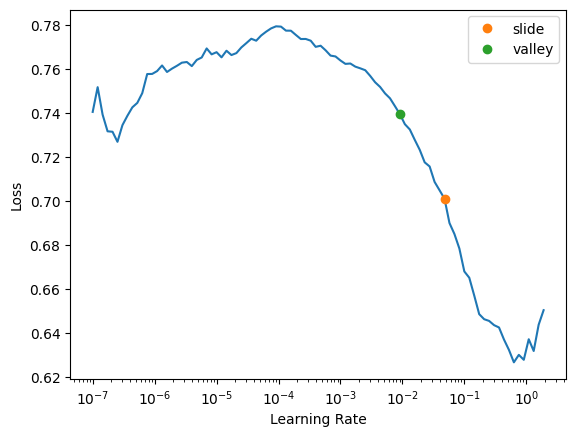

In [15]:
learn.lr_find(suggest_funcs=(slide, valley))

In [16]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.547859,0.590293,0.640449,00:00
1,0.508080,0.481419,0.803371,00:00
2,0.469510,0.442730,0.808989,00:00
3,0.449098,0.450369,0.842697,00:00
4,0.417549,0.428384,0.814607,00:00
5,0.415517,0.440583,0.848315,00:00
6,0.401478,0.438075,0.820225,00:00
7,0.396373,0.491749,0.775281,00:00
8,0.401140,0.465741,0.820225,00:00
9,0.392440,0.433571,0.848315,00:00


# **Test data**

In [17]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,1,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,0,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,1,1,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,1,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,0,1,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S,2.20,NaN,0,1,1,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C,4.70,ABC,0,1,1,NaN
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S,2.11,NaN,0,1,1,Mr
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S,2.20,NaN,0,1,1,Mr


Further data processing steps are not needed to be done separately for the test set, as all are saved in *learner*. Same steps are applied to a new dataset using test_dl()

In [18]:
tst_dl = learn.dls.test_dl(tst_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [19]:
#Getting predictions for the test set

preds,_ = learn.get_preds(dl=tst_dl)

In [20]:
#Saving the output

tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('pred_output.csv', index=False)

!head pred_output.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


# Ensembling

In **Ensembling**, multiple models are combined to generate predictions that are better than any of the single models in the ensemble. Here, 5 separate models, each trained from different random starting points, are collected and averaged over for the prediction.

To create an ensemble, first the three steps used above are copied to create and train a model, and then applied to the test set.

---
learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)

Trains the model for 16 epochs with a learning rate of 0.03.
no_bar(): Disables the progress bar during training.
no_logging(): Disables logging (e.g., no output to the console or files).

return learn.get_preds(dl=tst_dl)[0]

After training, the function generates predictions on the test dataset (tst_dl).
get_preds() returns a tuple: (predictions, targets). Here, [0] selects only the predictions.


In [21]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

It runs ensemble() function 5 times, creating 5 independently trained models.

Each model is trained with the same architecture and hyperparameters but starts with different random initializations (due to randomness in weight initialization and data shuffling).

The predictions from each model are stored in the 'learns' list

In [22]:
learns = [ensemble() for _ in range(5)]

The predictions are stacked together and their average is taken

In [23]:
ens_preds = torch.stack(learns).mean(0)
ens_preds.shape

# Number of Samples in test set: 418
# The survival prediction is a binary classification problem; Class 0: Did not survive, Class 1: Survived

torch.Size([418, 2])

In [24]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_pred_output.csv', index=False)

In [25]:
!head ens_pred_output.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
